#****Import Python Lib****

- ****pandas for data manipulation****

- ****numpy for numerical operations****

- ****matplotlib/seaborn for visualization****

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#****Data Preprocessing****

In [11]:
# Set display options for better readability
pd.set_option('display.max_columns', None)

# Load datasets
fear_greed_df = pd.read_csv('fear_greed_index.csv')
trade_df = pd.read_csv('historical_data.csv')

# Preprocess fear_greed_df
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'], format='%Y-%m-%d')

# Preprocess trade_df
# Convert 'Timestamp IST' to datetime and extract date for joining
trade_df['Timestamp IST'] = pd.to_datetime(trade_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
trade_df['date'] = trade_df['Timestamp IST'].dt.date
trade_df['date'] = pd.to_datetime(trade_df['date'])

# Filter for closed trades (non-zero Closed PnL)
closed_trades = trade_df[trade_df['Closed PnL'] != 0]

# Join datasets on date
merged_df = closed_trades.merge(fear_greed_df[['date', 'value', 'classification']],
                               left_on='date', right_on='date', how='inner')

# Check if merged_df is empty
if merged_df.empty:
    print("No matching trades found after joining datasets.")
else:
    # Calculate correlation between sentiment value and Closed PnL
    correlation = merged_df['value'].corr(merged_df['Closed PnL'])
    print(f"Correlation between Sentiment Value and Closed PnL: {correlation:.2f}")

    # Summary by Sentiment Classification
    summary_by_sentiment = merged_df.groupby('classification').agg({
        'Closed PnL': ['sum', 'mean', 'count', 'std']
    }).round(2)
    summary_by_sentiment.columns = ['Total PnL', 'Average PnL', 'Number of Trades', 'Std Dev of PnL']
    summary_by_sentiment = summary_by_sentiment.reset_index()
    summary_by_sentiment.to_csv('summary_sentiment.csv', index=False)
    print("\nSummary by Sentiment Classification:")
    print(summary_by_sentiment)

    # Summary by Account and Sentiment
    summary_by_account = merged_df.groupby(['Account', 'classification']).agg({
        'Closed PnL': ['sum', 'mean', 'count']
    }).round(2)
    summary_by_account.columns = ['Total PnL', 'Average PnL', 'Number of Trades']
    summary_by_account = summary_by_account.reset_index()
    summary_by_account.to_csv('summary_account.csv', index=False)
    print("\nSummary by Account and Sentiment:")
    print(summary_by_account)

    # Summary by Coin and Sentiment
    summary_by_coin = merged_df.groupby(['Coin', 'classification']).agg({
        'Closed PnL': ['sum', 'mean', 'count']
    }).round(2)
    summary_by_coin.columns = ['Total PnL', 'Average PnL', 'Number of Trades']
    summary_by_coin = summary_by_coin.reset_index()
    summary_by_coin.to_csv('summary_coin.csv', index=False)
    print("\nSummary by Coin and Sentiment:")
    print(summary_by_coin)



Correlation between Sentiment Value and Closed PnL: 0.01

Summary by Sentiment Classification:
  classification   Total PnL  Average PnL  Number of Trades  Std Dev of PnL
0   Extreme Fear   739110.25        71.03             10406         1628.41
1  Extreme Greed  2715171.31       130.21             20853         1058.13
2           Fear  3357155.44       112.63             29808         1344.78
3          Greed  2150129.27        85.40             25176         1576.39
4        Neutral  1292920.68        71.20             18159          743.21

Summary by Account and Sentiment:
                                        Account classification   Total PnL  \
0    0x083384f897ee0f19899168e3b1bec365f52a9012   Extreme Fear   124769.22   
1    0x083384f897ee0f19899168e3b1bec365f52a9012  Extreme Greed   -40282.34   
2    0x083384f897ee0f19899168e3b1bec365f52a9012           Fear  1113373.55   
3    0x083384f897ee0f19899168e3b1bec365f52a9012          Greed   276719.27   
4    0x083384f897ee0f198

#**Data** **Visualization**

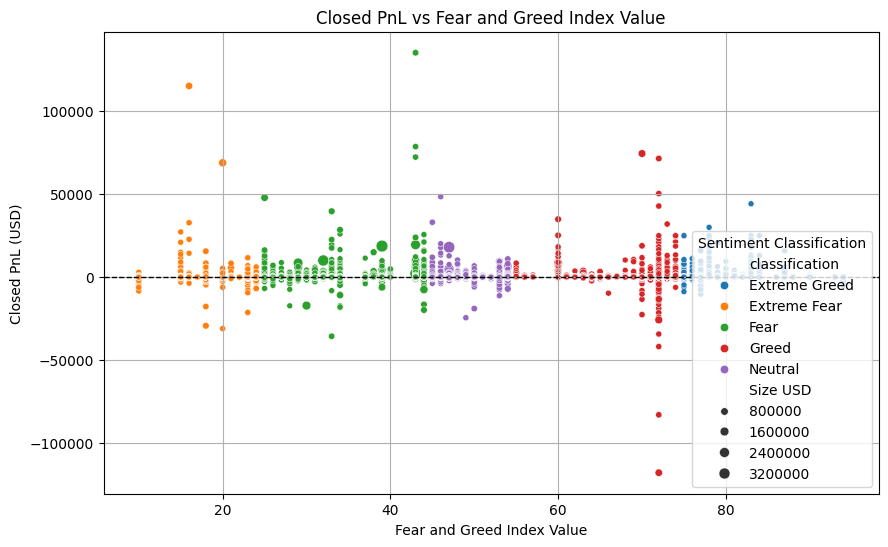

In [7]:
# Plot: Average PnL vs Sentiment Value
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='value', y='Closed PnL', hue='classification', size='Size USD')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Closed PnL vs Fear and Greed Index Value')
plt.xlabel('Fear and Greed Index Value')
plt.ylabel('Closed PnL (USD)')
plt.legend(title='Sentiment Classification')
plt.grid(True)
plt.show()

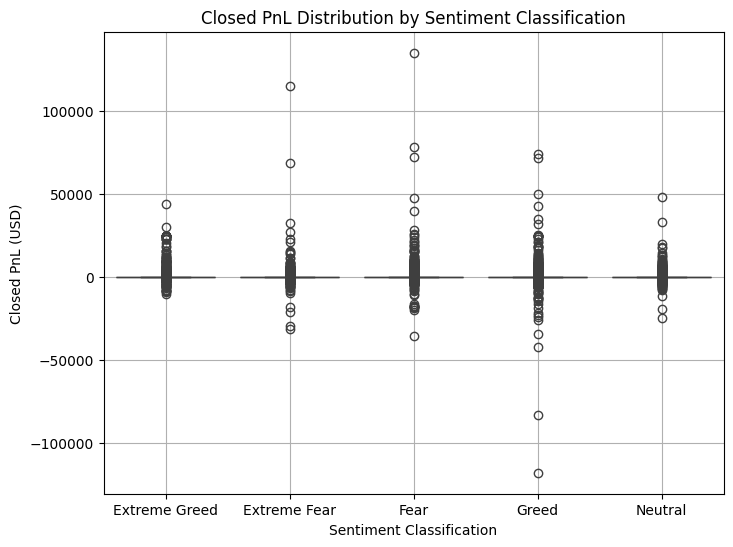

In [8]:
# Plot: Boxplot of PnL by Sentiment Classification
plt.figure(figsize=(8, 6))
sns.boxplot(data=merged_df, x='classification', y='Closed PnL')
plt.title('Closed PnL Distribution by Sentiment Classification')
plt.xlabel('Sentiment Classification')
plt.ylabel('Closed PnL (USD)')
plt.grid(True)
plt.show()

# **Insights and Recommendations**

**Insights** **for** **Trading** **Strategies**:

- **Buy in Fear, Sell in Extreme Greed**: Profitable trades occurred during Extreme Greed (values >75). Consider buying during Fear/Extreme Fear (<50) and selling at Extreme Greed peaks.

- **Avoid Holding Through Sentiment Shifts**: Losses were seen in Greed (60-75). Use sentiment drops as exit signals (e.g., close longs if value <70).

- **Risk Management for Volatile Coins**: FARTCOIN showed consistent losses in Greed. Use smaller position sizes and tight stops for volatile assets.

- **Diversify Timing and Assets**: Success in @107 during Extreme Greed suggests quick scalps in stable assets. Test buying in Fear for contrarian entries.

- **Monitor Sentiment in Real-Time**: Integrate Fear/Greed Index into strategies with alerts for entry/exit points.